In [13]:
from utils import *

# custom baseline
#predictions_path = r"predictions\custom_baseline.csv"

# resnet
#predictions_path = r"predictions\resnet.csv"

# mobilenet
#predictions_path = r"predictions\mobilenet.csv"

# resnet28 - Resnet with a resolution of 28x28
#predictions_path = r"predictions\resnet28.csv"

# reweighing with male 1.25 female 0.75
#predictions_path = r"predictions\reweigh25.csv"

# reweighing with male 1.5 female 0.5
predictions_path = r"predictions\reweigh50.csv"


df = parse_predictions(predictions_path)
df = df.drop(columns={'age_pred', 'race_pred'}, errors='ignore')

In [12]:
display(Markdown("## Fairness analysis of predictions made by the model"))

display(Markdown(f"Number of samples: {len(df)}"))
display(Markdown(f"Number of samples classified correctly: {len(df.loc[df['pred_true'] == 1])}"))
display(Markdown(f"Number of misclassified samples: {len(df.loc[df['pred_true'] == 0])}"))
display(Markdown(f"Accuracy: {len(df.loc[df['pred_true'] == 1]) / len(df):.3}"))

## Fairness analysis of predictions made by the model

Number of samples: 7040

Number of samples classified correctly: 6344

Number of misclassified samples: 696

Accuracy: 0.901

## Gender, race, and age distributions in the test set

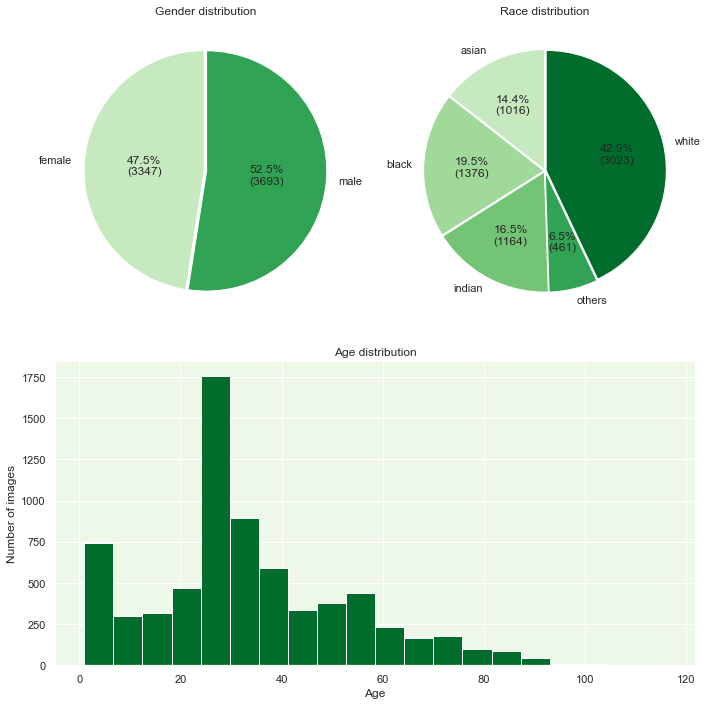

In [13]:
display(Markdown("## Gender, race, and age distributions in the test set"))

plot_distributions(convert_id_to_alias(df))

In [14]:
# rates and disparate impact for gender (manually)

male_positive = len(df.loc[(df['gender'] == 0) & (df['pred_true'] == 1)])
male_negative = len(df.loc[(df['gender'] == 0) & (df['pred_true'] == 0)])

female_positive = len(df.loc[(df['gender'] == 1) & (df['pred_true'] == 1)])
female_negative = len(df.loc[(df['gender'] == 1) & (df['pred_true'] == 0)])

mr = male_positive / (male_positive + male_negative)
fr = female_positive / (female_positive + female_negative)


print(f"Base rate male: {mr:.3f}\nBase rate female: {fr:.3f}\nDisparate impact female: {fr/mr:.3f}")

Base rate male: 0.929
Base rate female: 0.871
Disparate impact female: 0.938


In [15]:
# One hot encoding for age and race 

df_bld = df.drop(columns=['files', 'weights'], errors='ignore')

bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
df_bld['age'] = pd.cut(df_bld['age'], bins, labels=[0,1,2,3,4,5,6])

onehot = pd.get_dummies(df_bld['gender'], prefix='gender')
df_bld = df_bld.drop(columns='gender')
df_bld = df_bld.join(onehot)
df_bld = df_bld.rename(columns={'gender_0': 'male', 'gender_1': 'female'})

onehot = pd.get_dummies(df_bld['age'], prefix='age')
df_bld = df_bld.drop(columns='age')
df_bld = df_bld.join(onehot)

onehot = pd.get_dummies(df_bld['race'], prefix='race')
df_bld = df_bld.drop(columns='race')
df_bld = df_bld.join(onehot)

df_bld

,pred_true,male,female,age_0,age_1,age_2,age_3,age_4,age_5,age_6,race_0,race_1,race_2,race_3,race_4
0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0
1,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0
2,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0
3,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0
4,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7035,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0
7036,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0
7037,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0
7038,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0


In [16]:
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric

group = "female"

bld = BinaryLabelDataset(favorable_label=1, unfavorable_label=0, df=df_bld, label_names=['pred_true'], protected_attribute_names=[group])
bld_metric = BinaryLabelDatasetMetric(bld, unprivileged_groups=[{group: 1}], privileged_groups=[{group: 0}])

print(f"Disparate impact gender: {bld_metric.disparate_impact():.3f}")

Disparate impact gender: 0.938


In [17]:
groups = df_bld.columns.values.tolist()
groups.remove('pred_true')

scores = {}

for group in groups:
    bld = BinaryLabelDataset(favorable_label=1, unfavorable_label=0, df=df_bld, label_names=['pred_true'], protected_attribute_names=[group])
    bld_metric = BinaryLabelDatasetMetric(bld, unprivileged_groups=[{group: 1}], privileged_groups=[{group: 0}])

    score = bld_metric.disparate_impact()
    scores.setdefault('disparate_impact', {})[group] = score

    score = bld_metric.mean_difference()
    scores.setdefault('mean_difference', {})[group] = score

    score = bld_metric.base_rate(privileged=False)
    scores.setdefault('base_rate', {})[group] = score

    score = bld_metric.base_rate(privileged=True)
    scores.setdefault('base_rate_rest', {})[group] = score
    

## Fairness Metrics for all groups

### Base rate:

<IPython.core.display.Latex object>

### Disparate Impact:

<IPython.core.display.Latex object>

### Mean Difference:

<IPython.core.display.Latex object>

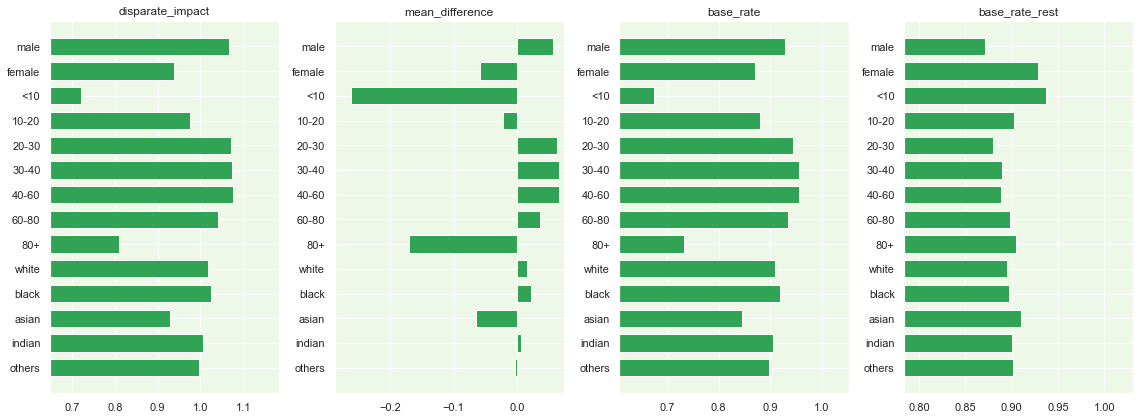

In [18]:
display(Markdown("## Fairness Metrics for all groups"))

# base rate
display(Markdown("### Base rate:"))
display(Latex('$Pr(Y = 1) = P/(P+N)$'))

#disparate impact
display(Markdown("### Disparate Impact:"))
display(Latex(r'$\frac{Pr(Y = 1 | D = \text{unprivileged})}{Pr(Y = 1 | D = \text{privileged})}$'))

# mean difference
display(Markdown("### Mean Difference:"))
display(Latex(r'$Pr(Y = 1 | D = \text{unprivileged}) - Pr(Y = 1 | D = \text{privileged})$'))



plot_scores_for_all_groups(scores)

In [19]:
df_scores = pd.DataFrame(scores)
df_scores.to_csv('scores_reweigh50.csv')